## 1) Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features.

With the data in the sakila database I will be using the following features for this logisict regression exercise
- film_id - (unique identifier)
- Ttl Number of rentals
- Ttl payment amount
- Rental Rate
- Number of special features
- Number of actors (A total number of films they've featured in)
- Rented Last month (The target variable) 

## 2) Read the data into a Pandas dataframe.

In [1]:
## Importing of libraries
import pandas as pd
import numpy as np
import pymysql
import sqlalchemy
from sqlalchemy import create_engine
import getpass
password = getpass.getpass()

········


In [2]:
# setting up connection string
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

In [3]:
# First table for film_id, rental_rate, special features, ttl rentals, and ttl_amount
query1 = 'SELECT f.film_id, f.rental_rate, special_features, \
COUNT(r.rental_id) AS ttl_rentals, SUM(p.amount) AS ttl_amount FROM rental r \
JOIN inventory i ON i.inventory_id = r.inventory_id \
JOIN payment p ON p.rental_id = r.rental_id \
RIGHT JOIN film f ON f.film_id = i.film_id \
GROUP BY f.film_id \
ORDER BY f.film_id ASC'

film_info = pd.read_sql_query(query1, engine)

film_info.head()

,film_id,rental_rate,special_features,ttl_rentals,ttl_amount
0,1,0.99,"Deleted Scenes,Behind the Scenes",23,36.77
1,2,4.99,"Trailers,Deleted Scenes",7,52.93
2,3,2.99,"Trailers,Deleted Scenes",12,37.88
3,4,2.99,"Commentaries,Behind the Scenes",23,91.77
4,5,2.99,Deleted Scenes,12,51.88


In [4]:
# Shape check
film_info.shape

(1681, 5)

In [5]:
# Creating actor experience table
query2 = 'WITH cte_act AS (SELECT * FROM actor_experience) \
SELECT f.film_id, sum(act.num_of_films) AS film_experience FROM cte_act act \
JOIN film_actor fa ON fa.actor_id = act.actor_id \
RIGHT JOIN film f ON f.film_id = fa.film_id \
GROUP BY f.film_id \
ORDER BY f.film_id'

actexp = pd.read_sql_query(query2, engine)

actexp.head()

,film_id,film_experience
0,1,278.0
1,2,109.0
2,3,136.0
3,4,141.0
4,5,141.0


In [6]:
# Shape check
actexp.shape

(1681, 2)

In [7]:
# Creating last moth table 
query3 = 'SELECT film_id, \
CASE \
	WHEN month_of_rental = 07 THEN "Yes" \
    ELSE "No" \
END AS "Rented This Month" \
FROM monthly_rentals \
GROUP BY film_id \
ORDER BY film_id'
 
lstmonthrentals = pd.read_sql_query(query3, engine)

lstmonthrentals.head()

,film_id,Rented This Month
0,1,No
1,2,No
2,3,No
3,4,No
4,5,No


In [8]:
# Shape check
lstmonthrentals.shape


(1681, 2)

In [9]:
# Merging all tables

merge1 = pd.merge(film_info, actexp, on ='film_id')

merge1.head()

,film_id,rental_rate,special_features,ttl_rentals,ttl_amount,film_experience
0,1,0.99,"Deleted Scenes,Behind the Scenes",23,36.77,278.0
1,2,4.99,"Trailers,Deleted Scenes",7,52.93,109.0
2,3,2.99,"Trailers,Deleted Scenes",12,37.88,136.0
3,4,2.99,"Commentaries,Behind the Scenes",23,91.77,141.0
4,5,2.99,Deleted Scenes,12,51.88,141.0


In [10]:
data1 = pd.merge(merge1, lstmonthrentals, on = 'film_id')

data1.head()

,film_id,rental_rate,special_features,ttl_rentals,ttl_amount,film_experience,Rented This Month
0,1,0.99,"Deleted Scenes,Behind the Scenes",23,36.77,278.0,No
1,2,4.99,"Trailers,Deleted Scenes",7,52.93,109.0,No
2,3,2.99,"Trailers,Deleted Scenes",12,37.88,136.0,No
3,4,2.99,"Commentaries,Behind the Scenes",23,91.77,141.0,No
4,5,2.99,Deleted Scenes,12,51.88,141.0,No


In [11]:
# Update column header "Rented Last Month"
data1.columns = data1.columns.str.replace(' ','')
data1.columns = data1.columns.str.lower()

data1.head()

,film_id,rental_rate,special_features,ttl_rentals,ttl_amount,film_experience,rentedthismonth
0,1,0.99,"Deleted Scenes,Behind the Scenes",23,36.77,278.0,No
1,2,4.99,"Trailers,Deleted Scenes",7,52.93,109.0,No
2,3,2.99,"Trailers,Deleted Scenes",12,37.88,136.0,No
3,4,2.99,"Commentaries,Behind the Scenes",23,91.77,141.0,No
4,5,2.99,Deleted Scenes,12,51.88,141.0,No


## 3) Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.

In [12]:
## Checking datatypes for each column
data1.dtypes

film_id               int64
rental_rate         float64
special_features     object
ttl_rentals           int64
ttl_amount          float64
film_experience     float64
rentedthismonth      object
dtype: object

- film_id is unique identifier but comes out as numerical
- special features and rented last month as categorical columns
- remove film_id? as info for each row will be unique anyway

In [13]:
# Checking for Nulls in columns
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1681 entries, 0 to 1680
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   film_id           1681 non-null   int64  
 1   rental_rate       1681 non-null   float64
 2   special_features  1681 non-null   object 
 3   ttl_rentals       1681 non-null   int64  
 4   ttl_amount        958 non-null    float64
 5   film_experience   997 non-null    float64
 6   rentedthismonth   1681 non-null   object 
dtypes: float64(3), int64(2), object(2)
memory usage: 105.1+ KB


- Notice that ttl_amount and ttl_experiennce have NaN's in their columns
- For ttl_amount, consider replacing NaN's with 0 as that could mean they have not been rented before
- For film_experience consider replacing NaN's with mean value of entire column

In [14]:
# Create copy of database 
data2 = data1.copy()

In [15]:
# Replacing NaN's in "ttl_amount" column
data2['ttl_amount'] = data2['ttl_amount'].fillna(0)

In [16]:
# Replacing NaN's in "film_experience" column
data2['film_experience'] = data2['film_experience'].fillna(data2['film_experience'].mean())

In [17]:
# Info check
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1681 entries, 0 to 1680
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   film_id           1681 non-null   int64  
 1   rental_rate       1681 non-null   float64
 2   special_features  1681 non-null   object 
 3   ttl_rentals       1681 non-null   int64  
 4   ttl_amount        1681 non-null   float64
 5   film_experience   1681 non-null   float64
 6   rentedthismonth   1681 non-null   object 
dtypes: float64(3), int64(2), object(2)
memory usage: 105.1+ KB


In [18]:
# Creation of numercial df to multicolinearity and describe info
nums = data2.select_dtypes(include = ['int64','float64'])
nums.head()

,film_id,rental_rate,ttl_rentals,ttl_amount,film_experience
0,1,0.99,23,36.77,278.0
1,2,4.99,7,52.93,109.0
2,3,2.99,12,37.88,136.0
3,4,2.99,23,91.77,141.0
4,5,2.99,12,51.88,141.0


In [19]:
# Checking numerical data
nums.describe()

,film_id,rental_rate,ttl_rentals,ttl_amount,film_experience
count,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000
mean,1255.433670,2.984051,9.544319,40.099084,154.539619
std,950.084747,1.269594,9.704594,47.254538,51.002449
min,1.000000,0.990000,0.000000,0.000000,18.000000
25%,421.000000,2.990000,0.000000,0.000000,138.000000
50%,841.000000,2.990000,8.000000,24.820000,154.539619
75%,2284.000000,2.990000,18.000000,70.800000,162.000000
max,2704.000000,4.990000,34.000000,231.730000,440.000000


- Potential scaling due to mean variance across columns

In [20]:
# Check for multicollinearity
nums.corr()

,film_id,rental_rate,ttl_rentals,ttl_amount,film_experience
film_id,1.000000,0.000726,-0.781308,-0.671593,0.001322
rental_rate,0.000726,1.000000,-0.032106,0.396969,-0.038751
ttl_rentals,-0.781308,-0.032106,1.000000,0.856556,0.018132
ttl_amount,-0.671593,0.396969,0.856556,1.000000,-0.002598
film_experience,0.001322,-0.038751,0.018132,-0.002598,1.000000


- Notice ttl_amount/ttl_rentals may have some correaltion so will remove ttl_amount due to correlation to both ttl_rentals and rental_rate

In [21]:
# Header check for finaldf2 database
data2.head()

,film_id,rental_rate,special_features,ttl_rentals,ttl_amount,film_experience,rentedthismonth
0,1,0.99,"Deleted Scenes,Behind the Scenes",23,36.77,278.0,No
1,2,4.99,"Trailers,Deleted Scenes",7,52.93,109.0,No
2,3,2.99,"Trailers,Deleted Scenes",12,37.88,136.0,No
3,4,2.99,"Commentaries,Behind the Scenes",23,91.77,141.0,No
4,5,2.99,Deleted Scenes,12,51.88,141.0,No


In [22]:
# Set film_id as the index for the dataframe and creation of "data3" df
data3 = data2.set_index(data2['film_id'])#

data3.head()

,film_id,rental_rate,special_features,ttl_rentals,ttl_amount,film_experience,rentedthismonth
film_id,,,,,,,
1,1,0.99,"Deleted Scenes,Behind the Scenes",23,36.77,278.0,No
2,2,4.99,"Trailers,Deleted Scenes",7,52.93,109.0,No
3,3,2.99,"Trailers,Deleted Scenes",12,37.88,136.0,No
4,4,2.99,"Commentaries,Behind the Scenes",23,91.77,141.0,No
5,5,2.99,Deleted Scenes,12,51.88,141.0,No


In [23]:
# Target variable column 'rentedlastmonth' to be dummified
# Checking unique values. If two, then manual 1 and 0 to be attributed to 'Yes' or 'No', if not to be dummified with special_features

data3.rentedthismonth.unique()

array(['No', 'Yes'], dtype=object)

In [24]:
# Dummify rentedlastmonthcolumn
data3['rentedthismonth'] = data3['rentedthismonth'].replace(['Yes','No'], [1,0])


In [25]:
# Unique value check
data3.rentedthismonth.unique()

array([0, 1], dtype=int64)

In [26]:
## Checking unique values for speical features column
data3.special_features.unique()

array(['Deleted Scenes,Behind the Scenes', 'Trailers,Deleted Scenes',
       'Commentaries,Behind the Scenes', 'Deleted Scenes', 'Trailers',
       'Commentaries,Deleted Scenes',
       'Trailers,Deleted Scenes,Behind the Scenes',
       'Trailers,Commentaries,Behind the Scenes', 'Trailers,Commentaries',
       'Trailers,Behind the Scenes',
       'Commentaries,Deleted Scenes,Behind the Scenes',
       'Trailers,Commentaries,Deleted Scenes',
       'Trailers,Commentaries,Deleted Scenes,Behind the Scenes',
       'Behind the Scenes', 'Commentaries'], dtype=object)

- Multiple strings in column. considering to switch to count of special features within each film_id or dummying the column?

In [27]:
# testing dummyifing to see number of columns
sftest = pd.get_dummies(data3[['special_features']])

sftest.head(15)

,special_features_Behind the Scenes,special_features_Commentaries,"special_features_Commentaries,Behind the Scenes","special_features_Commentaries,Deleted Scenes","special_features_Commentaries,Deleted Scenes,Behind the Scenes",special_features_Deleted Scenes,"special_features_Deleted Scenes,Behind the Scenes",special_features_Trailers,"special_features_Trailers,Behind the Scenes","special_features_Trailers,Commentaries","special_features_Trailers,Commentaries,Behind the Scenes","special_features_Trailers,Commentaries,Deleted Scenes","special_features_Trailers,Commentaries,Deleted Scenes,Behind the Scenes","special_features_Trailers,Deleted Scenes","special_features_Trailers,Deleted Scenes,Behind the Scenes"
film_id,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
8,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [28]:
# Getting unique values for dummified columns
sftest.special_features_Commentaries.unique()

array([0, 1], dtype=uint8)

- Number of new columns is fine and will use the dummifiying method

In [29]:
finaldata = pd.get_dummies(data3)

finaldata.head()

,film_id,rental_rate,ttl_rentals,ttl_amount,film_experience,rentedthismonth,special_features_Behind the Scenes,special_features_Commentaries,"special_features_Commentaries,Behind the Scenes","special_features_Commentaries,Deleted Scenes",...,special_features_Deleted Scenes,"special_features_Deleted Scenes,Behind the Scenes",special_features_Trailers,"special_features_Trailers,Behind the Scenes","special_features_Trailers,Commentaries","special_features_Trailers,Commentaries,Behind the Scenes","special_features_Trailers,Commentaries,Deleted Scenes","special_features_Trailers,Commentaries,Deleted Scenes,Behind the Scenes","special_features_Trailers,Deleted Scenes","special_features_Trailers,Deleted Scenes,Behind the Scenes"
film_id,,,,,,,,,,,,,,,,,,,,,
1,1,0.99,23,36.77,278.0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2,4.99,7,52.93,109.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,3,2.99,12,37.88,136.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,4,2.99,23,91.77,141.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,5,2.99,12,51.88,141.0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [30]:
# Dropping "film_id" and "ttl_amount" (correlation with ttl rentals is high) columns
finaldata = finaldata.drop(['film_id', 'ttl_amount'],axis = 1)

finaldata.head()

,rental_rate,ttl_rentals,film_experience,rentedthismonth,special_features_Behind the Scenes,special_features_Commentaries,"special_features_Commentaries,Behind the Scenes","special_features_Commentaries,Deleted Scenes","special_features_Commentaries,Deleted Scenes,Behind the Scenes",special_features_Deleted Scenes,"special_features_Deleted Scenes,Behind the Scenes",special_features_Trailers,"special_features_Trailers,Behind the Scenes","special_features_Trailers,Commentaries","special_features_Trailers,Commentaries,Behind the Scenes","special_features_Trailers,Commentaries,Deleted Scenes","special_features_Trailers,Commentaries,Deleted Scenes,Behind the Scenes","special_features_Trailers,Deleted Scenes","special_features_Trailers,Deleted Scenes,Behind the Scenes"
film_id,,,,,,,,,,,,,,,,,,,
1,0.99,23,278.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,4.99,7,109.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,2.99,12,136.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,2.99,23,141.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5,2.99,12,141.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


# 5) Create a logistic regression model to predict this variable from the cleaned data.

In [69]:
# Importing logistic regression and model analysis libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report

In [32]:
# X-Y Split
X = finaldata.drop(['rentedthismonth'], axis = 1)
y = finaldata['rentedthismonth']

In [33]:
# XY train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)

In [34]:
# Logistic Regression
clf = LogisticRegression(random_state = 100, max_iter = 500).fit(X_train, y_train)
predictions = clf.predict(X_test)

In [35]:
# Accuracy score


- Decent accuracy score but want to match it against confusion matrecall and precision results

The Kappa of your model is: 0.00
The accuracy of your model is:  0.9623762376237623


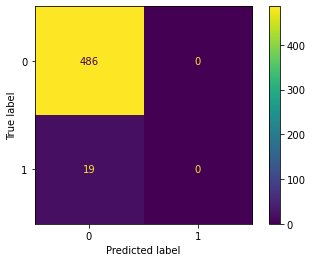

In [36]:
#Model Metrics 
plot_confusion_matrix(clf, X_test, y_test)
print("The Kappa of your model is: %4.2f" % (cohen_kappa_score(y_test, predictions)))
print("The accuracy of your model is: ", accuracy_score(y_test, predictions))

In [37]:
finaldata['rentedthismonth'].value_counts()

0    1630
1      51
Name: rentedthismonth, dtype: int64

- Very low Kappa score, but this was done without any scaler or normalizer
- Also very imbalanced data

# Recreating model but using scaler on numerical columns

In [38]:
# Import of libraries
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.stats import normaltest
import seaborn as sns
%matplotlib inline

In [39]:
# Create new df "finaldata2" for new model
finaldata2 = finaldata.copy()

C:\Users\sogun\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


NormaltestResult(statistic=34.347238596682985, pvalue=3.4801014498279426e-08)

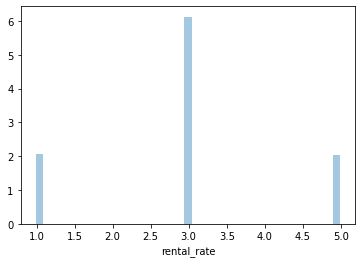

In [40]:
# Checking distributions of numercial columns
sns.distplot(finaldata2['rental_rate'])
normaltest(finaldata2['rental_rate'])

NormaltestResult(statistic=230.40125410979795, pvalue=9.311150754606172e-51)

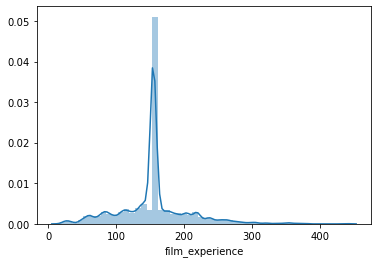

In [41]:
sns.distplot(finaldata2['film_experience'])
normaltest(finaldata2['film_experience'])

NormaltestResult(statistic=912.1778077047152, pvalue=8.377333396874758e-199)

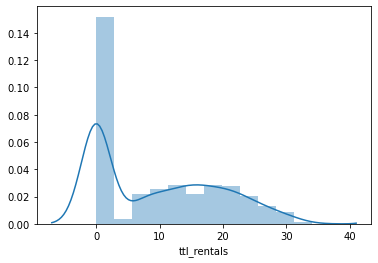

In [42]:
sns.distplot(finaldata2['ttl_rentals'])
normaltest(finaldata2['ttl_rentals'])

- Neither of numerical columns are normally distritbuted
- Very high p-values

In [43]:
# Scaling numerical columns - 'ttl_rentals'
scaler = StandardScaler()
scaler.fit(finaldata2[['ttl_rentals']])
finaldata2['ttl_rentals'] = scaler.transform(finaldata2[['ttl_rentals']])

finaldata2

,rental_rate,ttl_rentals,film_experience,rentedthismonth,special_features_Behind the Scenes,special_features_Commentaries,"special_features_Commentaries,Behind the Scenes","special_features_Commentaries,Deleted Scenes","special_features_Commentaries,Deleted Scenes,Behind the Scenes",special_features_Deleted Scenes,"special_features_Deleted Scenes,Behind the Scenes",special_features_Trailers,"special_features_Trailers,Behind the Scenes","special_features_Trailers,Commentaries","special_features_Trailers,Commentaries,Behind the Scenes","special_features_Trailers,Commentaries,Deleted Scenes","special_features_Trailers,Commentaries,Deleted Scenes,Behind the Scenes","special_features_Trailers,Deleted Scenes","special_features_Trailers,Deleted Scenes,Behind the Scenes"
film_id,,,,,,,,,,,,,,,,,,,
1,0.99,1.386940,278.000000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,4.99,-0.262255,109.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,2.99,0.253118,136.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,2.99,1.386940,141.000000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5,2.99,0.253118,141.000000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2700,2.99,-0.983777,154.539619,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2701,2.99,-0.983777,154.539619,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2702,2.99,-0.983777,154.539619,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [44]:
# Scaling numerical columns - 'film_experience'
scaler = StandardScaler()
scaler.fit(finaldata2[['film_experience']])
finaldata2['film_experience'] = scaler.transform(finaldata2[['film_experience']])

finaldata2

,rental_rate,ttl_rentals,film_experience,rentedthismonth,special_features_Behind the Scenes,special_features_Commentaries,"special_features_Commentaries,Behind the Scenes","special_features_Commentaries,Deleted Scenes","special_features_Commentaries,Deleted Scenes,Behind the Scenes",special_features_Deleted Scenes,"special_features_Deleted Scenes,Behind the Scenes",special_features_Trailers,"special_features_Trailers,Behind the Scenes","special_features_Trailers,Commentaries","special_features_Trailers,Commentaries,Behind the Scenes","special_features_Trailers,Commentaries,Deleted Scenes","special_features_Trailers,Commentaries,Deleted Scenes,Behind the Scenes","special_features_Trailers,Deleted Scenes","special_features_Trailers,Deleted Scenes,Behind the Scenes"
film_id,,,,,,,,,,,,,,,,,,,
1,0.99,1.386940,2.421396e+00,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,4.99,-0.262255,-8.931565e-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,2.99,0.253118,-3.636127e-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,2.99,1.386940,-2.655490e-01,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5,2.99,0.253118,-2.655490e-01,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2700,2.99,-0.983777,5.574275e-16,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2701,2.99,-0.983777,5.574275e-16,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2702,2.99,-0.983777,5.574275e-16,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [45]:
# Scaling numerical columns - 'rental_rate'
scaler = StandardScaler()
scaler.fit(finaldata2[['rental_rate']])
finaldata2['rental_rate'] = scaler.transform(finaldata2[['rental_rate']])

finaldata2

,rental_rate,ttl_rentals,film_experience,rentedthismonth,special_features_Behind the Scenes,special_features_Commentaries,"special_features_Commentaries,Behind the Scenes","special_features_Commentaries,Deleted Scenes","special_features_Commentaries,Deleted Scenes,Behind the Scenes",special_features_Deleted Scenes,"special_features_Deleted Scenes,Behind the Scenes",special_features_Trailers,"special_features_Trailers,Behind the Scenes","special_features_Trailers,Commentaries","special_features_Trailers,Commentaries,Behind the Scenes","special_features_Trailers,Commentaries,Deleted Scenes","special_features_Trailers,Commentaries,Deleted Scenes,Behind the Scenes","special_features_Trailers,Deleted Scenes","special_features_Trailers,Deleted Scenes,Behind the Scenes"
film_id,,,,,,,,,,,,,,,,,,,
1,-1.571088,1.386940,2.421396e+00,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,1.580462,-0.262255,-8.931565e-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0.004687,0.253118,-3.636127e-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0.004687,1.386940,-2.655490e-01,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5,0.004687,0.253118,-2.655490e-01,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2700,0.004687,-0.983777,5.574275e-16,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2701,0.004687,-0.983777,5.574275e-16,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2702,0.004687,-0.983777,5.574275e-16,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


C:\Users\sogun\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


NormaltestResult(statistic=34.34723859668281, pvalue=3.480101449828251e-08)

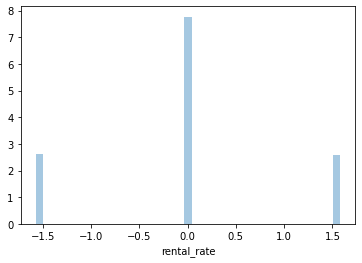

In [46]:
# Checking for new distplots
sns.distplot(finaldata2['rental_rate'])
normaltest(finaldata2['rental_rate'])

NormaltestResult(statistic=230.40125410979743, pvalue=9.311150754608574e-51)

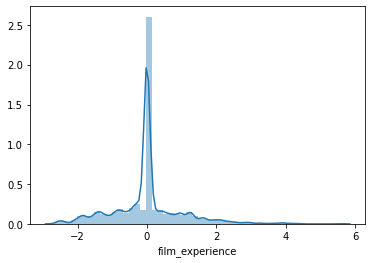

In [47]:
# Checking for new distplots
sns.distplot(finaldata2['film_experience'])
normaltest(finaldata2['film_experience'])

NormaltestResult(statistic=912.1778077047152, pvalue=8.377333396874758e-199)

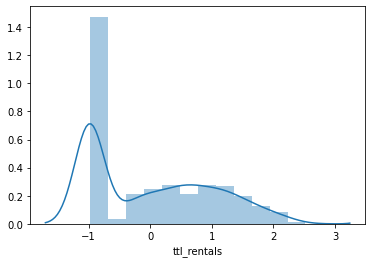

In [48]:
# Checking for new distplots
sns.distplot(finaldata2['ttl_rentals'])
normaltest(finaldata2['ttl_rentals'])

- No real change in any of the shapes but x-axis has changed

In [49]:
# Creating new logistic regression model using new scaled numerical columns
# X-Y Split
X1 = finaldata2.drop(['rentedthismonth'], axis = 1)
y1 = finaldata2['rentedthismonth']

In [50]:
# XY train test split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.3, random_state = 100)

In [51]:
# Regression on scaled numerical columns
clf1 = LogisticRegression(random_state = 100, max_iter = 500).fit(X1_train, y1_train)
predictions1 = clf1.predict(X1_test)

The Kappa of your model is: 0.00
The accuracy score is:  0.9623762376237623


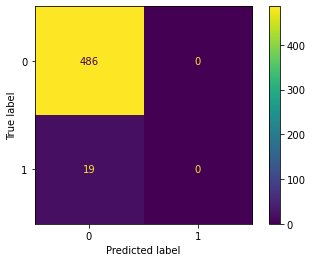

In [52]:
# Model Metrics
plot_confusion_matrix(clf1, X1_test, y1_test)
print("The Kappa of your model is: %4.2f" % (cohen_kappa_score(y1_test, predictions1)))
print("The accuracy score is: ", accuracy_score(y_test, predictions))

- No change in model will try to Normalize the numerical columns now

# Using Normalizer on numerical columns

In [53]:
# from sklearn.preprocessing import Normalizer - DID NOT WORK ONLY 1'S AND 0'S
from sklearn.preprocessing import MinMaxScaler

In [54]:
# Creating new dataframe to be used in Normalization
finaldata3 = finaldata.copy()
finaldata3

,rental_rate,ttl_rentals,film_experience,rentedthismonth,special_features_Behind the Scenes,special_features_Commentaries,"special_features_Commentaries,Behind the Scenes","special_features_Commentaries,Deleted Scenes","special_features_Commentaries,Deleted Scenes,Behind the Scenes",special_features_Deleted Scenes,"special_features_Deleted Scenes,Behind the Scenes",special_features_Trailers,"special_features_Trailers,Behind the Scenes","special_features_Trailers,Commentaries","special_features_Trailers,Commentaries,Behind the Scenes","special_features_Trailers,Commentaries,Deleted Scenes","special_features_Trailers,Commentaries,Deleted Scenes,Behind the Scenes","special_features_Trailers,Deleted Scenes","special_features_Trailers,Deleted Scenes,Behind the Scenes"
film_id,,,,,,,,,,,,,,,,,,,
1,0.99,23,278.000000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,4.99,7,109.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,2.99,12,136.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,2.99,23,141.000000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5,2.99,12,141.000000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2700,2.99,0,154.539619,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2701,2.99,0,154.539619,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2702,2.99,0,154.539619,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [55]:
# Using Normalizer on columns
transformer = MinMaxScaler()
transformer.fit(finaldata3[['ttl_rentals']])
finaldata3['ttl_rentals'] = transformer.transform(finaldata3[['ttl_rentals']])

finaldata3

,rental_rate,ttl_rentals,film_experience,rentedthismonth,special_features_Behind the Scenes,special_features_Commentaries,"special_features_Commentaries,Behind the Scenes","special_features_Commentaries,Deleted Scenes","special_features_Commentaries,Deleted Scenes,Behind the Scenes",special_features_Deleted Scenes,"special_features_Deleted Scenes,Behind the Scenes",special_features_Trailers,"special_features_Trailers,Behind the Scenes","special_features_Trailers,Commentaries","special_features_Trailers,Commentaries,Behind the Scenes","special_features_Trailers,Commentaries,Deleted Scenes","special_features_Trailers,Commentaries,Deleted Scenes,Behind the Scenes","special_features_Trailers,Deleted Scenes","special_features_Trailers,Deleted Scenes,Behind the Scenes"
film_id,,,,,,,,,,,,,,,,,,,
1,0.99,0.676471,278.000000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,4.99,0.205882,109.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,2.99,0.352941,136.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,2.99,0.676471,141.000000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5,2.99,0.352941,141.000000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2700,2.99,0.000000,154.539619,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2701,2.99,0.000000,154.539619,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2702,2.99,0.000000,154.539619,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [56]:
# Using Normalizer on columns
transformer = MinMaxScaler()
transformer.fit(finaldata3[['rental_rate']])
finaldata3['rental_rate'] = transformer.transform(finaldata3[['rental_rate']])

finaldata3

,rental_rate,ttl_rentals,film_experience,rentedthismonth,special_features_Behind the Scenes,special_features_Commentaries,"special_features_Commentaries,Behind the Scenes","special_features_Commentaries,Deleted Scenes","special_features_Commentaries,Deleted Scenes,Behind the Scenes",special_features_Deleted Scenes,"special_features_Deleted Scenes,Behind the Scenes",special_features_Trailers,"special_features_Trailers,Behind the Scenes","special_features_Trailers,Commentaries","special_features_Trailers,Commentaries,Behind the Scenes","special_features_Trailers,Commentaries,Deleted Scenes","special_features_Trailers,Commentaries,Deleted Scenes,Behind the Scenes","special_features_Trailers,Deleted Scenes","special_features_Trailers,Deleted Scenes,Behind the Scenes"
film_id,,,,,,,,,,,,,,,,,,,
1,0.0,0.676471,278.000000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,1.0,0.205882,109.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0.5,0.352941,136.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0.5,0.676471,141.000000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5,0.5,0.352941,141.000000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2700,0.5,0.000000,154.539619,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2701,0.5,0.000000,154.539619,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2702,0.5,0.000000,154.539619,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [57]:
transformer = MinMaxScaler()
transformer.fit(finaldata3[['film_experience']])
finaldata3['film_experience'] = transformer.transform(finaldata3[['film_experience']])

finaldata3

,rental_rate,ttl_rentals,film_experience,rentedthismonth,special_features_Behind the Scenes,special_features_Commentaries,"special_features_Commentaries,Behind the Scenes","special_features_Commentaries,Deleted Scenes","special_features_Commentaries,Deleted Scenes,Behind the Scenes",special_features_Deleted Scenes,"special_features_Deleted Scenes,Behind the Scenes",special_features_Trailers,"special_features_Trailers,Behind the Scenes","special_features_Trailers,Commentaries","special_features_Trailers,Commentaries,Behind the Scenes","special_features_Trailers,Commentaries,Deleted Scenes","special_features_Trailers,Commentaries,Deleted Scenes,Behind the Scenes","special_features_Trailers,Deleted Scenes","special_features_Trailers,Deleted Scenes,Behind the Scenes"
film_id,,,,,,,,,,,,,,,,,,,
1,0.0,0.676471,0.616114,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,1.0,0.205882,0.215640,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0.5,0.352941,0.279621,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0.5,0.676471,0.291469,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5,0.5,0.352941,0.291469,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2700,0.5,0.000000,0.323554,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2701,0.5,0.000000,0.323554,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2702,0.5,0.000000,0.323554,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


C:\Users\sogun\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


NormaltestResult(statistic=34.34723859668263, pvalue=3.4801014498285593e-08)

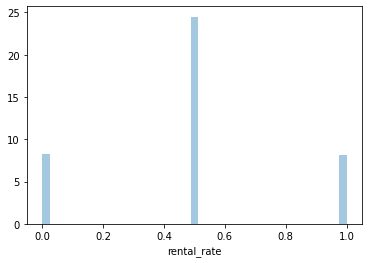

In [58]:
# Checking distplot of MinMaxScaled columns
sns.distplot(finaldata3['rental_rate'])
normaltest(finaldata3['rental_rate'])

NormaltestResult(statistic=912.177807704717, pvalue=8.377333396867124e-199)

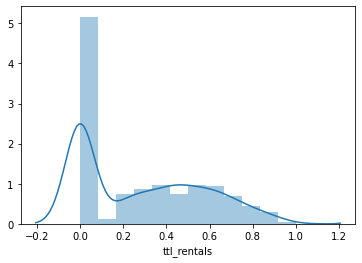

In [59]:
sns.distplot(finaldata3['ttl_rentals'])
normaltest(finaldata3['ttl_rentals'])

NormaltestResult(statistic=230.40125410979772, pvalue=9.31115075460724e-51)

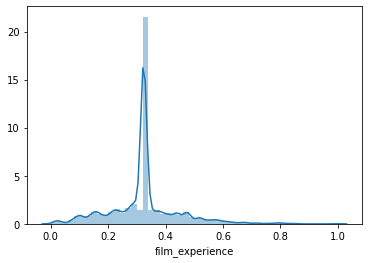

In [60]:
sns.distplot(finaldata3['film_experience'])
normaltest(finaldata3['film_experience'])

- No change in shapes but significant change in x axis

In [61]:
# Running Logistc Regression model on 'MinMaxed' data
X2 = finaldata3.drop(['rentedthismonth'], axis = 1)
y2 = finaldata3['rentedthismonth']

In [62]:
#X-Y train-test split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.3, random_state = 100)

In [63]:
# Regression Analysis
clf2 = LogisticRegression(random_state = 100, max_iter = 500).fit(X2_train, y2_train)
predictions2 = clf2.predict(X2_test)

The Kappa of your model is: 0.00
The accuracy score is:  0.9623762376237623


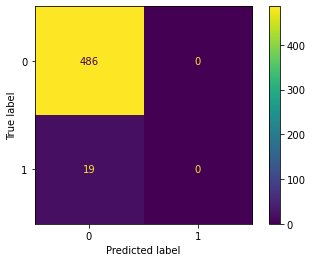

In [64]:
# Model Metrics
plot_confusion_matrix(clf2, X2_test, y2_test)
print("The Kappa of your model is: %4.2f" % (cohen_kappa_score(y2_test, predictions2)))
print("The accuracy score is: ", accuracy_score(y2_test, predictions2))

- No change at all due to heavy imbalanced data
- Will need to go through imbalanced data method to sort out final model

# Use SMOTE method

In [65]:
# Import SMOTE library
from imblearn.over_sampling import SMOTE
smote = SMOTE()

X_sm, y_sm = smote.fit_sample(X, y)
y_sm = pd.DataFrame(data=y_sm.values.flatten())

y_sm[0].value_counts()

1    1630
0    1630
Name: 0, dtype: int64

In [66]:
# Train split on SMOTE varaibles
X_sm_train, X_sm_test, y_sm_train, y_sm_test = train_test_split(X_sm, y_sm, test_size=0.3, random_state=100)

In [81]:
# Running Logistic Regression again with SMOTE variables
clfsm = LogisticRegression(random_state = 100, max_iter = 500).fit(X_sm_train, y_sm_train)
y_sm_test_pred = clfsm.predict(X_sm_test)

C:\Users\sogun\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



The Kappa of your model is: 0.85
The accuracy score of the model is: 0.92
              precision    recall  f1-score   support

           1       1.00      0.84      0.92       473
           0       0.87      1.00      0.93       505

    accuracy                           0.92       978
   macro avg       0.94      0.92      0.92       978
weighted avg       0.93      0.92      0.92       978



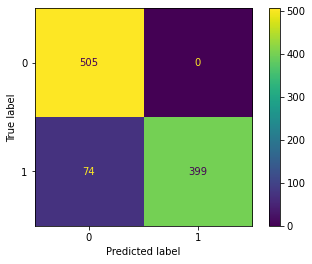

In [84]:
# Confusion Matrix and Accuracy Score
plot_confusion_matrix(clfsm, X_sm_test, y_sm_test) 
print()
print("The Kappa of your model is: %4.2f" % (cohen_kappa_score(y_sm_test, predictionssm)))
print("The accuracy score of the model is: %4.2f" % (clfsm.score(X_sm_test, y_sm_test)))
print(classification_report(y_sm_test, y_sm_test_pred, labels=[1,0]))